In [30]:
from dotenv import load_dotenv
load_dotenv()

import torch
import torchtext
from torchtext.datasets import AG_NEWS
import pandas as pd

from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD, Adam
import time
from tqdm.auto import tqdm
from recommender.engine.pre_agent.training import accuracy_function

import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence, pack_padded_sequence

from transformers import XLNetModel, XLNetTokenizer

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# def label2vec(label, classes_no):
#     label_vec = torch.zeros(classes_no, dtype=torch.float32)
#     label_vec[int(label-1)] = 1
#     return label_vec

In [33]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [34]:
def text2ids(text, tokenizer):
    tokenized_texts = tokenizer.tokenize(text)
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    return input_ids

In [35]:
def collate_batch(batch):
    labels = []
    lines_ids = []
    for line, label in batch:
        labels.append(label)
        lines_ids.append(torch.tensor(text2ids(line, tokenizer)))
    labels = torch.tensor(labels).reshape(-1,1).float()
    features = pad_sequence(lines_ids, batch_first=True)
    attention_mask = (features > 0).float()
    return labels.to(device), features.to(device), attention_mask.to(device)

In [36]:
raw_ds = pd.read_csv("./tweets.csv",encoding="UTF-8")
numpy_ds = raw_ds[["text", "target"]].to_numpy()

classes_no = len(raw_ds["target"].unique())

all_size = numpy_ds.shape[0]
train_size = int(0.6*all_size)
valid_size = int(0.2*all_size)

train_ds = numpy_ds[:train_size]
valid_ds = numpy_ds[train_size:train_size+valid_size]
test_ds = numpy_ds[train_size+valid_size:]

In [37]:
train_ds_dl = DataLoader(train_ds, batch_size=32, shuffle=False, collate_fn=collate_batch)
valid_ds_dl = DataLoader(valid_ds, batch_size=32, shuffle=False, collate_fn=collate_batch)
test_ds_dl = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [38]:
batch = next(iter(train_ds_dl))
labels, features, attention_masks = batch

In [39]:
# print(labels.shape)
# print(features.shape)
# print(attention_masks.shape)

In [40]:
# print(labels)
# print(features)
# print(attention_masks)

In [41]:
# print(labels[5])
# print(features[5])
# print(attention_masks[5])

In [42]:
# def get_last_sequence_values(batch, indices):
#     last_values = []
#     indices = indices-2
#     for i, seq in enumerate(batch):
#         last_values.append(seq[indices[i]])
#     return torch.stack(last_values)
        

In [43]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
#         self.num_layers = num_layers
#         self.embeding_dim = embeding_dim
        
#         self.rnn = torch.nn.LSTM(
#             input_size=embeding_dim,
#             hidden_size=embeding_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=0.2
#         )
        
#         self.fc1 = torch.nn.Linear(embeding_dim, 512)
#         self.fc2 = torch.nn.Linear(512, classes_no)
        
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        self.fc1 = torch.nn.Linear(768, 128)
        self.fc2 = torch.nn.Linear(128, 1)
        
    def forward(self, input_ids, attention_mask):
        
#         packed_input = pack_padded_sequence(features, lengths, batch_first=True, enforce_sorted=False)
#         packed_output, _ = self.rnn(packed_input)
#         output, _ = pad_packed_sequence(packed_output, batch_first=True)
#         out_forward = torch.mean(features, 1)
        
#         out_forward = output[range(len(output)), lenghts - 1, :self.embeding_dim]
#         out_forward = get_last_sequence_values(output, lengths)
        
        last_hidden_state = self.xlnet(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=None
        )
        
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
        
        x = self.fc1(mean_last_hidden_state)
        x = F.sigmoid(x)
        
        x = self.fc2(x)
        x = F.sigmoid(x)

        return x

    def pool_hidden_state(self, last_hidden_state):
        """
        Pool the output vectors into a single mean vector 
        """
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state
    
    def freeze_xlnet_decoder(self):
        """
        Freeze XLNet weight parameters. They will not be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = False
    
    def unfreeze_xlnet_decoder(self):
        """
        Unfreeze XLNet weight parameters. They will be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = True

In [44]:
model = MyModel().to(device)
model.freeze_xlnet_decoder()

In [45]:
preds = torch.tensor([0.1, 0.5001, 0.7]).reshape(-1,1).float()
print(preds)

targets = torch.tensor([0, 1, 0]).reshape(-1,1).float()
print(targets)

tensor([[0.1000],
        [0.5001],
        [0.7000]])
tensor([[0.],
        [1.],
        [0.]])


In [46]:
def accuracy_function(preds, targets):
    processed_preds = torch.round(preds).bool()
    processed_targets = targets.bool()
    equality = processed_preds == processed_targets
    x = torch.sum(equality,1)/processed_targets.shape[1]
    x = torch.mean(x)
    return x.item()

In [47]:
accuracy_function(preds, targets)

0.6666666865348816

In [48]:
def evaluate(model, dataloader, loss_function, accuracy_function):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            labels, features, attention_masks = batch
            preds = model(features, attention_masks)
            loss = loss_function(preds, labels).item()
            acc = accuracy_function(preds, labels)
        return loss, acc

In [49]:
# TODO: return ndentation in evaluate in pycharm !!!!

In [50]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [51]:
loss_function = torch.nn.BCELoss()
LR = 0.01
optimizer = Adam(model.parameters(), lr=LR)

losses = []
accuracies = []

val_losses = []
val_accuracies = []

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

  0%|          | 0/214 [00:00<?, ?batch/s]

Total training time: 673.024759054184


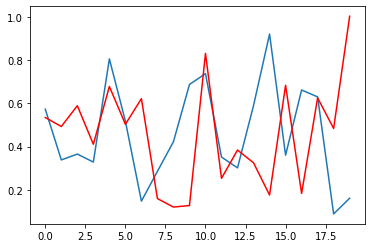

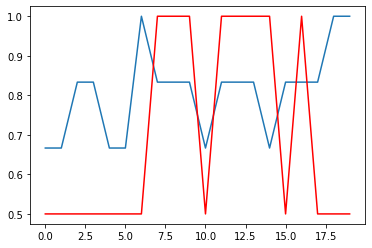

Testing loss: 1.003000259399414, testing accuracy: 0.5


In [52]:
batch_size=32

EPOCHS = 20

start = time.time()
for epoch in range(EPOCHS):
    with tqdm(train_ds_dl, unit="batch") as tepoch:
        model.train()
        for batch in tepoch:
            tepoch.set_description(f"[Epoch {epoch}]")
            labels, features, attention_masks = batch
            preds = model(features, attention_masks)

            loss = loss_function(preds, labels)
            acc = accuracy_function(preds, labels)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            optimizer.zero_grad()

            loss = loss.item()
            tepoch.set_postfix(loss=loss, acc=acc)

        losses.append(loss)
        accuracies.append(acc)
        writer.add_scalar("Loss/train", loss, epoch)
        writer.add_scalar("Accuracy/train", acc, epoch)
        writer.flush()

        val_loss, val_acc = evaluate(
            model, test_ds_dl, loss_function, accuracy_function
        )
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        writer.add_scalar("Loss/valid", val_loss, epoch)
        writer.add_scalar("Accuracy/valid", val_acc, epoch)
        writer.flush()
        
        tepoch.set_postfix(loss=loss, acc=acc, val_loss=val_loss, val_acc=val_acc)

end = time.time()
print(f"Total training time: {end - start}")

plt.plot([float(loss) for loss in losses])
plt.plot([float(loss) for loss in val_losses], color="red")
plt.show()

plt.plot([float(acc) for acc in accuracies])
plt.plot([float(acc) for acc in val_accuracies], color="red")
plt.show()

loss, acc = evaluate(model, test_ds_dl, loss_function, accuracy_function)
print(f"Testing loss: {loss}, testing accuracy: {acc}")

In [261]:
torch.cuda.empty_cache()